<a href="https://colab.research.google.com/github/trvslhlt/ift_6390_machine_learning/blob/learning-problem/exercises/01_learning_problem/examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN

Exercises from [course notes](https://pierrelucbacon.com/mlbook/knn/#exercices)

**Run all cells to verify your setup.**

In [1]:
# ==============================================================================
# Environment Setup - Run this cell first!
# ==============================================================================
# This cell handles both local and Google Colab environments.
# Copy this cell to the start of every notebook.

import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    import subprocess

    REPO_URL = "https://github.com/trvslhlt/ift_6390_machine_learning.git"
    REPO_PATH = Path("/content/ift_6390_machine_learning")

    if REPO_PATH.exists():
        print("Updating repository...")
        subprocess.run(["git", "-C", str(REPO_PATH), "pull"], check=True)
    else:
        print("Cloning repository...")
        subprocess.run(["git", "clone", REPO_URL, str(REPO_PATH)], check=True)

    print("Installing dependencies...")
    %pip install -q -e {REPO_PATH}

    sys.path.insert(0, str(REPO_PATH / "src"))
    %cd {REPO_PATH}
else:
    # Local: find repo root and add src to path
    REPO_PATH = Path.cwd()
    while not (REPO_PATH / "pyproject.toml").exists() and REPO_PATH != REPO_PATH.parent:
        REPO_PATH = REPO_PATH.parent
    sys.path.insert(0, str(REPO_PATH / "src"))

print(f"\nEnvironment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Repository: {REPO_PATH}")


Environment: Local
Repository: /Users/travisholt/Documents/github/trvslhlt/ift_6390_machine_learning


## Exercise 1: Manual Classification

Considérez les points d'entraînement suivants en 2D:

| Point | $x_1$ | $x_2$ | Classe |
|-------|-------|-------|--------|
| A | 0 | 0 | 0 |
| B | 1 | 0 | 0 |
| C | 0 | 1 | 1 |
| D | 2 | 2 | 1 |
| E | 3 | 1 | 1 |

1. Pour le point requête $x = (1, 1)$, identifiez les 3 plus proches voisins avec la distance euclidienne. Quelle est la prédiction du 3-ppv?

2. Répétez avec $k = 1$ et $k = 5$. Les prédictions changent-elles?

3. Calculez les distances avec la norme $\ell_1$ (Manhattan). Les 3 plus proches voisins sont-ils les mêmes?

In [ ]:
import math

# hyperparams
k = 3

# samples
A = [0, 0, 0]
B = [1, 0, 0]
C = [0, 1, 1]
D = [2, 2, 1]
E = [3, 1, 1]
points = [A, B, C, D, E]

# to predict
x = [1, 1]

# compute distances
def distance(p1, p2):
    return math.sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2))
distances = [(distance(x, point[:2]), point[-1]) for point in points]
distances.sort(key=lambda d: d[0])

## note:
# there are samples with the same distance from the test point that have different classes.
# how we determine the nearest neighbors may affect the final prediction.
print(distances)

# get nearest neighbors
neighbors = distances[:k]

# count class occurrences
counts: dict[int, int] = {}
for neighbor in neighbors:
    dist, c = neighbor
    count = counts.get(c, 0)
    counts[c] = count + 1

# get most common class in neighbors
prediction = max(counts, key=lambda c: counts.get(c, 0))
print(f"The predicted class for point {x} is: {prediction}")

[(1.0, 0), (1.0, 1), (1.4142135623730951, 0), (1.4142135623730951, 1), (2.0, 1)]
The predicted class for point [1, 1] is: 0


## Example 2: Effect of Normalization

Un jeu de données contient deux variables: l'âge (entre 20 et 70 ans) et le revenu annuel (entre 20 000 et 200 000 dollars).

1. Calculez la distance euclidienne entre les points $x_1 = (30, 50000)$ et $x_2 = (35, 51000)$.

2. Calculez la distance entre $x_1 = (30, 50000)$ et $x_3 = (31, 150000)$.

3. Laquelle des deux paires est "plus proche"? Ce résultat est-il intuitivement raisonnable?

4. Proposez une transformation des données qui rendrait les deux variables comparables. Recalculez les distances après transformation.

In [ ]:
import math

def l2_distance(p1, p2):
    return math.sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2))

# 1
x1 = [30, 50000]
x2 = [35, 51000]
x1_x2_distance = l2_distance(x1, x2) 
print(f'{x1_x2_distance=}')

# 2
x3 = [31 ,150000]
x1_x3_distance = l2_distance(x1, x3) 
print(f'{x1_x3_distance=}')

# 3
print(f'x1 is closer to x2 than x3: {x1_x2_distance < x1_x3_distance}\n')
## this makes sense because the greatest contribution to these distances comes from the income feature
## which is largest between x1 and x3.
## But, we are likely interested in both features so we need to do something to make them comparable.

# 4
## we can normalize the features to have values 
def normalize_min_max(p, in_ranges, out_ranges):
    x_in_range, y_in_range = in_ranges
    x_out_range, y_out_range = out_ranges
    x = (p[0] - x_in_range[0]) / (x_in_range[1] - x_in_range[0]) * (x_out_range[1] - x_out_range[0]) + x_out_range[0]
    y = (p[1] - y_in_range[0]) / (y_in_range[1] - y_in_range[0]) * (y_out_range[1] - y_out_range[0]) + y_out_range[0]
    return [x, y]

def normalize_standardization(p, means, stddevs):
    x = (p[0] - means[0]) / stddevs[0]
    y = (p[1] - means[1]) / stddevs[1]
    return [x, y]

in_ranges = [(20, 60), (0, 200000)]
out_ranges = [(0, 1), (0, 1)]
x1_normalized = normalize_min_max(x1, in_ranges, out_ranges)
x2_normalized = normalize_min_max(x2, in_ranges, out_ranges)
x3_normalized = normalize_min_max(x3, in_ranges, out_ranges)
print(f'{x1_normalized=}, {x2_normalized=}, {x3_normalized=}')

x1_x2_distance_normalized = l2_distance(x1_normalized, x2_normalized) 
x1_x3_distance_normalized = l2_distance(x1_normalized, x3_normalized) 
print(f'{x1_x2_distance_normalized=}')
print(f'{x1_x3_distance_normalized=}')
print(f'x1 is closer to x2 than x3 (normalized_min_max): {x1_x2_distance_normalized < x1_x3_distance_normalized}\n')

means = [45, 110000]
stddevs = [15, 60000]
x1_standardized = normalize_standardization(x1, means, stddevs)
x2_standardized = normalize_standardization(x2, means, stddevs)
x3_standardized = normalize_standardization(x3, means, stddevs)
print(f'{x1_standardized=}, {x2_standardized=}, {x3_standardized=}')

x1_x2_distance_standardized = l2_distance(x1_standardized, x2_standardized) 
x1_x3_distance_standardized = l2_distance(x1_standardized, x3_standardized) 
print(f'{x1_x2_distance_standardized=}')
print(f'{x1_x3_distance_standardized=}')
print(f'x1 is closer to x2 than x3 (standardized): {x1_x2_distance_standardized < x1_x3_distance_standardized}\n')

x1_x2_distance=1000.0124999218759
x1_x3_distance=100000.000005
x1 is closer to x2 than x3: True

x1_normalized=[0.25, 0.25], x2_normalized=[0.375, 0.255], x3_normalized=[0.275, 0.75]
x1_x2_distance_normalized=0.12509996003196805
x1_x3_distance_normalized=0.5006246098625197
x1 is closer to x2 than x3 (normalized_min_max): True

x1_standardized=[-1.0, -1.0], x2_standardized=[-0.6666666666666666, -0.9833333333333333], x3_standardized=[-0.9333333333333333, 0.6666666666666666]
x1_x2_distance_standardized=0.33374973990834644
x1_x3_distance_standardized=1.667999467092907
x1 is closer to x2 than x3 (standardized): True



## Exercise 3: Bias-variance trade-off

Soit un problème de régression 1D où la vraie fonction est $f(x) = \sin(2\pi x)$ et les observations sont bruitées: $y = f(x) + \varepsilon$ avec $\varepsilon \sim \mathcal{N}(0, 0.1)$.

1. Générez 50 points d'entraînement uniformément répartis sur $[0, 1]$.

2. Implémentez la régression k-ppv et tracez les prédictions pour $k = 1, 5, 20, 50$.

3. Calculez l'erreur quadratique moyenne (MSE) sur un ensemble de test de 200 points pour chaque valeur de $k$.

4. Tracez le MSE en fonction de $k$. Quelle valeur de $k$ minimise l'erreur de test?

5. Que se passe-t-il quand $k = N$ (nombre total de points d'entraînement)?

Lowest MSE is for k=3 with MSE=0.0058828278487967674


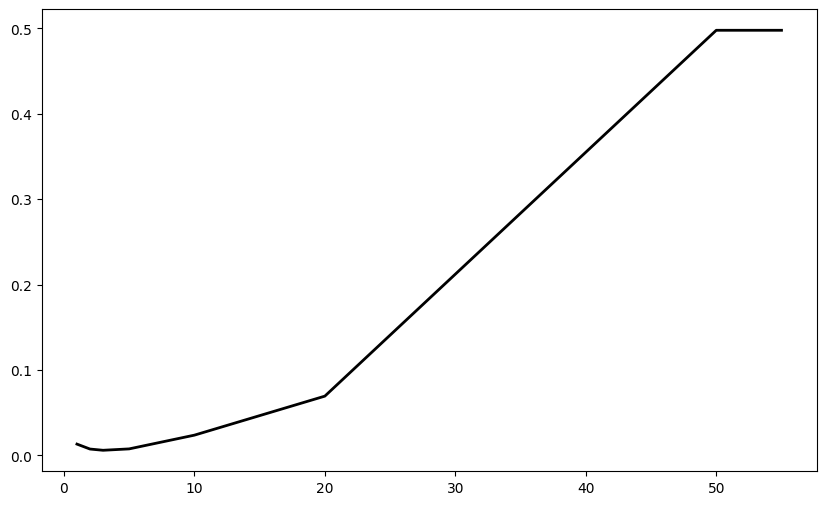

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
figure_size = (10, 6)
N = 50

# 1
X_train = np.linspace(0, 1, N)
y_train = np.sin(2 * np.pi * X_train) + np.random.randn(N) * 0.1
# 2
def knn_regression(train_X, train_y, test_X, k):
    predictions = []
    for x in test_X:
        distances = np.abs(train_X - x)
        knn_indices = np.argsort(distances)[:k]
        knn_values = train_y[knn_indices]
        prediction = np.mean(knn_values)
        predictions.append(prediction)
    return np.array(predictions)

# 3 - 4
ks = [1, 2, 3, 5, 10, 20, N, N + 5]
X_test = np.linspace(0, 1, 200)
y_test_true = np.sin(2 * np.pi * X_test)
y_tests = {k: knn_regression(X_train, y_train, X_test, k) for k in ks}

MSEs = {k: np.mean((y_tests[k] - y_test_true) ** 2) for k in ks}
lowest_mse_k = min(MSEs, key=lambda k: MSEs[k])
print(f'Lowest MSE is for k={lowest_mse_k} with MSE={MSEs[lowest_mse_k]}')

# 5
plt.figure(figsize=figure_size)
plt.plot(list(MSEs.keys()), list(MSEs.values()), label='True function', color='black', linewidth=2)